In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymaverick import spline
from pymaverick import solver as slv

In [1]:
# Model params
mp = {
    # model parameters
    'g':         9.81,
    'k_fm':      0.737 / 3600,  # density of gasoline
    'rho':       1.225,
    'eta_P':     1000 * 0.85,  #kw to watt plus propeller efficiency

    # inital and final states
    'x_i':       0,
    'x_f':       700 * 1000,  # Travel for 700km
    'm_i':       500,  # starts at 500kg
    'm_f_max':   501,
    'm_f_min':   420,  # No more than 60kg of fuel are burned

    # states, controls and parameters bounds
    'x_min':     0,
    'x_max':     2000000,
    'm_min':     100,
    'm_max':     501,
    'V_min':     30/3.6,
    'V_max':     400/3.6,
    'alpha_min': 0,
    'alpha_max': 10,
    'T_min':     1e-1,
    'T_max':     3600*10,
    'f_min':     0,
    'f_max':     28,  # Max fuel rate [l/hr]

    # guess
    't_guess':   1000,
    'V_guess': 100/3.6,
    'f_guess': 10,

    # target: with such values the solution minimizes the fuel consumption
    'wmt':       0,
    'wmm':       1,
    'wl2':       0,
    'wl1':       0,
}

In [2]:
rotax = pd.read_csv('data/rotax_912.csv')
airfold = pd.read_csv('data/airfold.csv')
airfold.cl *= 10  # To make the stall speed lower
airfold.cd *= 10  + 30 # To make the max speed lower

In [3]:
# Debug the data
stall_speed = math.sqrt(mp['g']*mp['m_i']*2/mp['rho']/airfold.cl.max())
print('Stall speed is {:.1f}km/h'.format(stall_speed*3.6))

max_speed = (rotax.power.max() * mp['eta_P'] * 2/mp['rho']/airfold.cd.min())**(1/3)
print('Approx max speed is {:.1f}km/h'.format(max_speed*3.6))

mass_1h = rotax.fuel_rate.mean() * mp['k_fm'] * 3600
print('Average mass lost in 1 hour: {:.1f}kg'.format(mass_1h))

Stall speed is 83.2km/h
Approx max speed is 181.6km/h
Average mass lost in 1 hour: 10.0kg


In [4]:
# Plot the data
cd_spline = spline.Spline1D("akima", airfold.alpha.values, airfold.cd.values)
cl_spline = spline.Spline1D("akima", airfold.alpha.values, airfold.cl.values)
p_spline = spline.Spline1D("akima", rotax.fuel_rate.values, rotax.power.values)

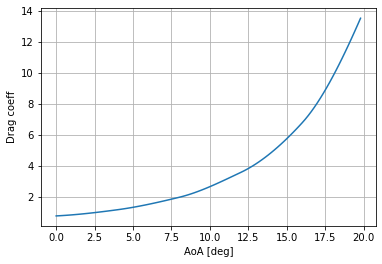

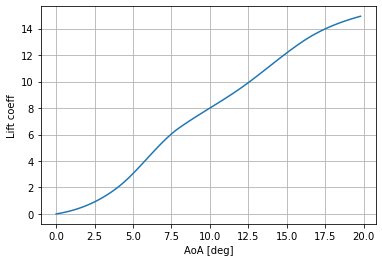

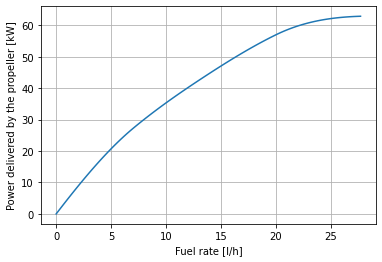

In [5]:
plt.figure()
x = np.arange(100)/100*20
plt.plot(x, cd_spline.eval(x))
plt.ylabel('Drag coeff')
plt.xlabel('AoA [deg]')
plt.grid(True)

plt.figure()
plt.plot(x, cl_spline.eval(x))
plt.ylabel('Lift coeff')
plt.xlabel('AoA [deg]')
plt.grid(True)

plt.figure()
x = np.arange(100)/100*28
plt.plot(x, p_spline.eval(x) * mp['eta_P'] / 1000)
plt.ylabel('Power delivered by the propeller [kW]')
plt.xlabel('Fuel rate [l/h]')
plt.grid(True)

In [6]:
solver_data = {
    'info_level' : 4,

    'Model' : {

        'Parameters': mp,
        
        'MappedObjects': {
            'C_l': cl_spline,
            'C_d': cd_spline,
            'P': p_spline,
        },

        'Scaling' : {
            'Phase0' : {
                'target' : 100,
                'states_and_controls' : "automatic-bounds",
                'algebraic_states_and_controls' : "automatic-bounds",
                'parameters' : "automatic-bounds",
                'fo_equations' : [100/3.6, 10 * 0.737 * 3600, 500, 500*10], # automatic bounds is not allowed for equations
                'boundary_conditions': [1000,500,1000,500], # h_i, V_i, fpa_i, m_i, h_f, V_f, fpa_f
            },
        },

    },

    'Mesh' : {
        'max_iterations' : 5,
        'tolerance' : 1e-7,
        'Phase0' : {
           'Segments' : [ {'length' : 1, 'num_points' : 100} ],
        },
    },

    'Solver' : {
        'max_iterations' : 300,
        'nlp_solver' : "Ipopt",
        'info_level': 1,
        'IpoptOptions' : {
            'linear_solver' : "ma57",
            'ma57_automatic_scaling' : "yes",
            'mu_strategy' : "adaptive",
            'check_derivatives_for_naninf' : "yes",
        },
    },
}

In [ ]:
solver = slv.Solver('./sources/libHorFlightMinFuel.so')

In [7]:
output = solver.solve(solver_data)

Setting up ocp problem ...
OCP model parameters detail:
      k_fm    2.047222e-04
         g    9.810000e+00
       rho    1.225000e+00
     eta_P    8.500000e+02
       x_i    0.000000e+00
       m_i    5.000000e+02
       x_f    7.000000e+05
   m_f_min    4.200000e+02
   m_f_max    5.010000e+02
     x_min    0.000000e+00
     m_min    1.000000e+02
     x_max    2.000000e+06
     m_max    5.010000e+02
     V_min    8.333333e+00
 alpha_min    0.000000e+00
     V_max    1.111111e+02
 alpha_max    1.000000e+01
     f_min    0.000000e+00
     f_max    2.800000e+01
     T_min    1.000000e-01
     T_max    3.600000e+04
   t_guess    1.000000e+03
   V_guess    2.777778e+01
   f_guess    1.000000e+01
       wmt    0.000000e+00
       wmm    1.000000e+00
       wl1    0.000000e+00
       wl2    0.000000e+00

Setting up mesh ...
Setting up nlp scaling ...
Scaling factors details:
Phase0
	target: 100
	states and controls: 2e+06, 401, 
	algebraic states and controls: 102.778, 10, 28, 
	parameter

In [8]:
output['history'][-1]['solver_return_status']

'converged_optimal_solution'

In [9]:
sol = output['solution']['Phase0']

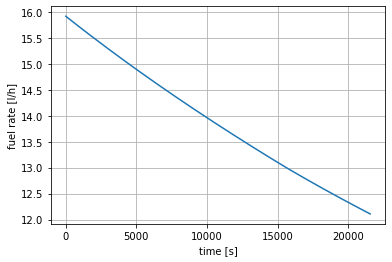

In [10]:
plt.figure()
plt.plot(sol['t'],sol['f'])
plt.xlabel('time [s]')
plt.ylabel('fuel rate [l/h]')
plt.grid(True)

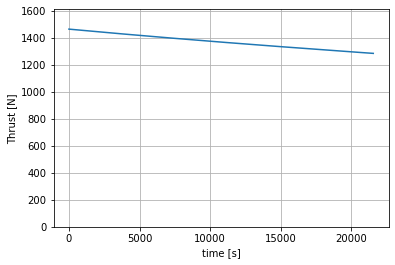

In [11]:
plt.figure()
plt.plot(sol['t'],sol['Thrust'])
plt.xlabel('time [s]')
plt.ylabel('Thrust [N]')
plt.ylim(bottom=0, top=max(sol['Thrust'])*1.1)
plt.grid(True)

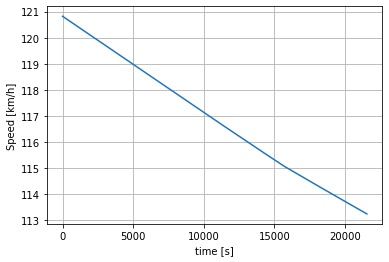

In [12]:
plt.figure()
plt.plot(sol['t'],np.array(sol['V'])*3.6)
plt.xlabel('time [s]')
plt.ylabel('Speed [km/h]')
plt.grid(True)

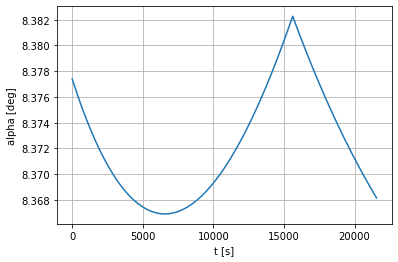

In [13]:
plt.figure()
plt.plot(sol['t'],sol['alpha'])
plt.xlabel('t [s]')
plt.ylabel('alpha [deg]')
plt.grid(True)

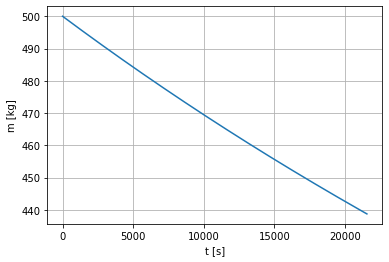

In [14]:
plt.figure()
plt.plot(sol['t'],sol['m'])
plt.xlabel('t [s]')
plt.ylabel('m [kg]')
#plt.ylim(bottom=300, top=501)
plt.grid(True)